# Sentiment Analysis

## Load the Data

### Import

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('ggplot')

### Merging Datasets

Because of the dataset size, this dataset is not included in the GitHub repository. 

1. To use this notebook please go to the following link to download the whole dataset:

    [Sephora Products and Skincare Reviews](https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews?select=product_info.csv)

2. Create a directory called `data` in the same directory as this notebook

3. Make sure the directory names in the `file_paths` list match with the dataset location and name


Alternatively you can also change the `file_paths` list as you wish

Combine all reviews into one file

In [2]:
file_paths = ['./data/archive/reviews_0-250.csv',
              './data/archive/reviews_250-500.csv',
              './data/archive/reviews_500-750.csv',
              './data/archive/reviews_750-1250.csv',
              './data/archive/reviews_1250-end.csv']

dataframes = [pd.read_csv(file) for file in file_paths]

/var/folders/16/59f4vdfs1j10515946gfx2mm0000gn/T/ipykernel_70115/1848543797.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in file_paths]
/var/folders/16/59f4vdfs1j10515946gfx2mm0000gn/T/ipykernel_70115/1848543797.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in file_paths]
/var/folders/16/59f4vdfs1j10515946gfx2mm0000gn/T/ipykernel_70115/1848543797.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in file_paths]


Concatenate all DataFrames

In [3]:
df = pd.concat(dataframes, ignore_index=True)

In [4]:
df.head()

,review_id,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [5]:
df.shape

(1094411, 19)

Now we have over 1 million reviews together

## EDA

### Brief look into features

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094411 entries, 0 to 1094410
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   review_id                 1094411 non-null  int64  
 1   author_id                 1094411 non-null  object 
 2   rating                    1094411 non-null  int64  
 3   is_recommended            926423 non-null   float64
 4   helpfulness               532819 non-null   float64
 5   total_feedback_count      1094411 non-null  int64  
 6   total_neg_feedback_count  1094411 non-null  int64  
 7   total_pos_feedback_count  1094411 non-null  int64  
 8   submission_time           1094411 non-null  object 
 9   review_text               1092967 non-null  object 
 10  review_title              783757 non-null   object 
 11  skin_tone                 923872 non-null   object 
 12  eye_color                 884783 non-null   object 
 13  skin_type                 9

Determining the __essential__, __possible enhancement__ and __further analysis__ features

In [7]:
essential_features = ['review_id',
                      'review_text',        # most critical, body of text
                      'product_id']         # will be important for the whole recommendation system

enhancing_features = ['rating',             # might help
                      'review_title',       # can also be analyzed
                      'is_recommended',
                      'author_id']     # can be used to quickly analyze sentiment ***
                          

further_features = ['submission_time',              # sentiment change over time
                    'helpfulness',
                    'total_feedback_count',
                    'total_neg_feedback_count',     # can give context to weight and reception of review
                    'skin_tone',
                    'eye_color',
                    'skin_type',
                    'hair_color',                   # if we use personalization later
                    'brand_name',
                    'price_usd']                    # sentiment across brands or price ranges

### Prepare essential DataFrame

In [8]:
df_essential = df[essential_features + enhancing_features]

In [9]:
df_essential.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835


Drop rows with missing reviews

In [10]:
df_essential = df_essential.dropna(subset=['review_text'])

In [11]:
df_essential.shape

(1092967, 7)

### Clean special characters from reviews

In [12]:
# Regex approach to remove any special characters other than alphabet, numbers and whitespace
# but we might need basic smiley emoticons like :), :(, etc.

#df_essential['review_text'] = df_essential['review_text'].str.lower().replace('[^a-z0-9\s]', '', regex=True)

Here is hopefully a better approach to remove unwanted characters while keeping the emoticons which actually contribute to the sentiment analysis. For example:

Without proper handling following reviews might be treated wrongly

`"I love this product:)"`

`":)great product"`

In those cases they might get split into words and we might end up with words like 

`"product:)"`
and
`":)great"`

Or even the combined cases such as:

`"I love this product:)great"`

will be separated into first:

`"I love this product :)great"`

and then 

`"I love this product :) great"`

The following function aims to make sure emoticons are separated from the words:

In [13]:
# Function to clean text and preserve emoticons
def clean_text(text):
    emoticons = r"(:\)|:\(|;\)|:D|:P)"

    # Separate emoticons from text
    # Ensure space between words and emoticons
    clean_txt = re.sub(r'([a-z0-9])([:;][()DP])', r'\1 \2', text.lower())
    # Ensure space between emoticons and words
    clean_txt = re.sub(r'([:;][()DP])([a-z0-9])', r'\1 \2', clean_txt)
    
    # Retain letters, numbers, spaces, basic emoticons, and certain punctuation marks
    clean_txt = re.sub(r'[^a-z0-9\s:;()DP!?\'\.,’]', '', clean_txt)
    
    return clean_txt

Applying the function to the DataFrame

In [14]:
df_essential['cleaned_review_text'] = df_essential['review_text'].apply(clean_text)

In [15]:
df_essential[['review_text', 'cleaned_review_text']].head(10)

,review_text,cleaned_review_text
0,I use this with the Nudestix “Citrus Clean Bal...,i use this with the nudestix citrus clean balm...
1,I bought this lip mask after reading the revie...,i bought this lip mask after reading the revie...
2,My review title says it all! I get so excited ...,my review title says it all! i get so excited ...
3,I’ve always loved this formula for a long time...,i’ve always loved this formula for a long time...
4,"If you have dry cracked lips, this is a must h...","if you have dry cracked lips, this is a must h..."
5,The scent isn’t my favourite but it works grea...,the scent isn’t my favourite but it works grea...
6,I’ll give this 2 stars for nice packaging and ...,i’ll give this 2 stars for nice packaging and ...
7,I use this at night or while I’m putting makeu...,i use this at night or while i’m putting makeu...
8,I love this stuff. I first had the sample size...,i love this stuff. i first had the sample size...
9,I purchased the Sweet Candy scent at my local ...,i purchased the sweet candy scent at my local ...


Check for empty reviews after cleaning

In [16]:
empty_reviews = df_essential['cleaned_review_text'].str.strip().replace('', pd.NA)
df_essential['cleaned_review_text'] = empty_reviews # update column with stripped strings/empty values

empty_count = df_essential['cleaned_review_text'].isna().sum()
print(f"Number of empty reviews after cleaning: {empty_count}")

Number of empty reviews after cleaning: 5


Remove these from the DataFrame

In [17]:
original_size = df_essential.shape[0]
df_essential = df_essential.dropna(subset=['cleaned_review_text'])
new_size = df_essential.shape[0]

print(f"Removed {original_size - new_size} rows with empty reviews.")

Removed 5 rows with empty reviews.


### Check for duplicates

Here the approach is to remove duplicate:

- Same product_id 
- Same author_id
- Same review_text      -> Remove

In [18]:
df_essential.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092962 entries, 0 to 1094410
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   review_id            1092962 non-null  int64  
 1   review_text          1092962 non-null  object 
 2   product_id           1092962 non-null  object 
 3   rating               1092962 non-null  int64  
 4   review_title         783754 non-null   object 
 5   is_recommended       924974 non-null   float64
 6   author_id            1092962 non-null  object 
 7   cleaned_review_text  1092962 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 75.0+ MB


In [19]:
# Remove duplicate reviews from the same person
df_essential = df_essential.drop_duplicates(subset=['author_id', 'product_id', 'review_text'])
print("Data size after removing true duplicates:", df_essential.shape)

Data size after removing true duplicates: (1092406, 8)


### Brief summary so far

1. Checked the datasets and merged the reviews into one DataFrame
2. Categorized the features
3. Cleaned special characters (like #)
4. Removed duplicate reviews from the same person for the same product 


### Basic Visualizations & NLTK Tests

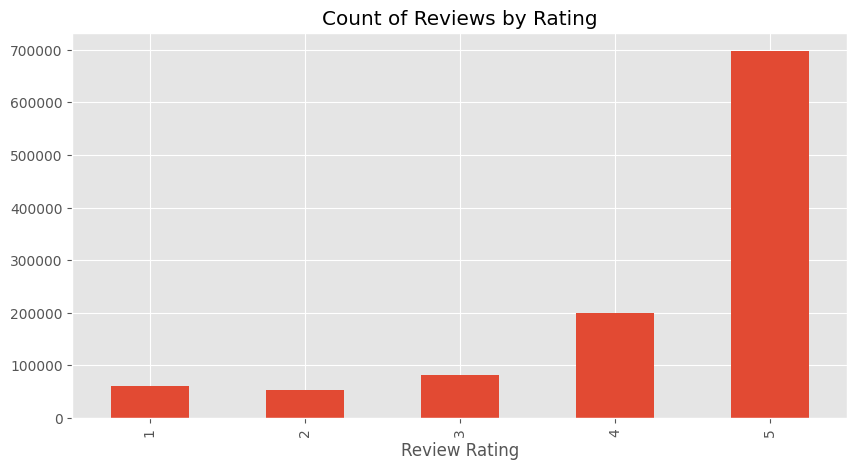

In [20]:
ax = df_essential['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Rating',
          figsize=(10, 5))
ax.set_xlabel('Review Rating')
plt.show()

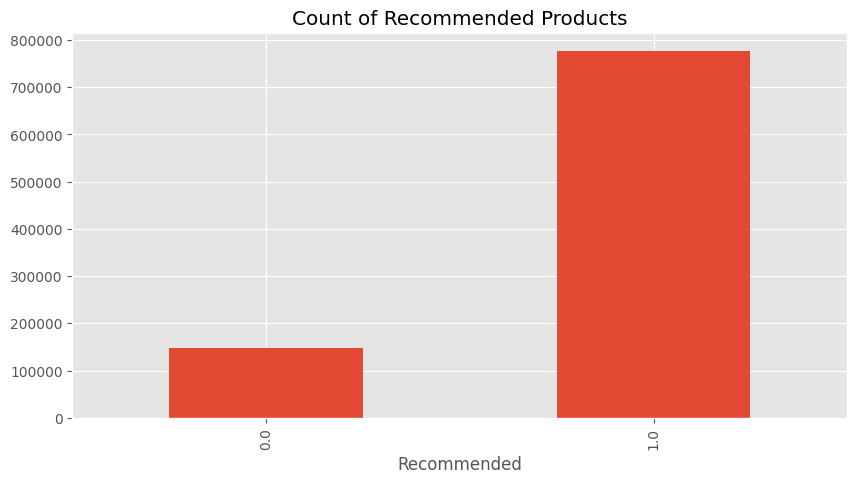

In [21]:
ax = df_essential['is_recommended'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Recommended Products',
          figsize=(10, 5))
ax.set_xlabel('Recommended')
plt.show()

A random review to be used as example

In [22]:
example = df_essential['review_text'][1337]
print(example)

Wow! Can’t go a night without putting this on! It’s incredible


Tokenization

In [23]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Wow', '!', 'Can', '’', 't', 'go', 'a', 'night', 'without', 'putting']

POS-Tagging

In [24]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Wow', 'IN'),
 ('!', '.'),
 ('Can', 'MD'),
 ('’', 'VB'),
 ('t', 'RB'),
 ('go', 'VB'),
 ('a', 'DT'),
 ('night', 'NN'),
 ('without', 'IN'),
 ('putting', 'VBG')]

Download `maxent_ne_chunker`

The `maxent_ne_chunker` contains two pre-trained English named entity chunkers trained on an ACE corpus

https://catalog.ldc.upenn.edu/LDC2005T09

In [25]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [26]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [27]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Wow/IN
  !/.
  Can/MD
  ’/VB
  t/RB
  go/VB
  a/DT
  night/NN
  without/IN
  putting/VBG
  this/DT
  on/IN
  !/.
  It/PRP
  ’/VBD
  s/RBR
  incredible/JJ)


### VADER Sentiment Scoring

#### Short Description

Vader (Valence Aware Dictionary and Sentiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed for analyzing social media texts. Vader is a pre-trained sentiment analysis model that provides a sentiment score for a given text.

Vader uses a dictionary of words and rules to determine the sentiment of a piece of text. It uses a valence score for each word to determine its positivity or negativity. The valence score ranges from -4 to +4, with -4 being the most negative and +4 being the most positive.

Uses "bag of words" approach
- Stopwords are removed
- Each word is scored and combined into total score

Some bulletpoints about VADER:
- Lexicon and rule-based model that relies on predefined list of words and meanings
- Uses simple rules to analyze sentiments
- Might misinterpret context 
- It is static, doesn't adapt after initial development
- Performance is based on the dictionary it uses
- Primarily focuses on English
- Requires manual addition of lexicon and rule-set 

Link: https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e#:~:text=Vader%20uses%20a%20dictionary%20of,4%20being%20the%20most%20positive.

#### Installing necessities

In [28]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

analyzer = SentimentIntensityAnalyzer()

#### Some simple examples

In [30]:
analyzer.polarity_scores('This is a very good product')

{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.4927}

In [31]:
analyzer.polarity_scores('This is the worst product ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [32]:
# Trying with the example from above
analyzer.polarity_scores(example)

{'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'compound': 0.658}

#### Polarity score on the DataFrame

In [33]:
# let's try with 500 rows before I break my stuff
df_sub = df_essential.iloc[:500].copy()

In [34]:
df_sub.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id,cleaned_review_text
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524,i use this with the nudestix citrus clean balm...
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263,i bought this lip mask after reading the revie...
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401,my review title says it all! i get so excited ...
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851,i’ve always loved this formula for a long time...
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835,"if you have dry cracked lips, this is a must h..."


In [35]:
def get_polarity_scores(text):
    return analyzer.polarity_scores(text)

In [36]:
df_sub['polarity_score'] = df_sub['review_text'].apply(get_polarity_scores)

In [37]:
df_sub.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id,cleaned_review_text,polarity_score
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524,i use this with the nudestix citrus clean balm...,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp..."
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263,i bought this lip mask after reading the revie...,"{'neg': 0.079, 'neu': 0.825, 'pos': 0.096, 'co..."
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401,my review title says it all! i get so excited ...,"{'neg': 0.052, 'neu': 0.905, 'pos': 0.042, 'co..."
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851,i’ve always loved this formula for a long time...,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp..."
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835,"if you have dry cracked lips, this is a must h...","{'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compou..."


In [38]:
df_sub['neg'] = df_sub['polarity_score'].apply(lambda x: x['neg'])
df_sub['neu'] = df_sub['polarity_score'].apply(lambda x: x['neu'])
df_sub['pos'] = df_sub['polarity_score'].apply(lambda x: x['pos'])
df_sub['compound'] = df_sub['polarity_score'].apply(lambda x: x['compound'])

df_sub = df_sub.drop('polarity_score', axis=1)

In [39]:
df_sub.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id,cleaned_review_text,neg,neu,pos,compound
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524,i use this with the nudestix citrus clean balm...,0.000,0.806,0.194,0.9392
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263,i bought this lip mask after reading the revie...,0.079,0.825,0.096,0.1280
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401,my review title says it all! i get so excited ...,0.052,0.905,0.042,-0.1240
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851,i’ve always loved this formula for a long time...,0.000,0.707,0.293,0.9460
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835,"if you have dry cracked lips, this is a must h...",0.000,0.940,0.060,0.3291


#### Plot VADER Results

Looking at Rating vs. VADER Compound Score

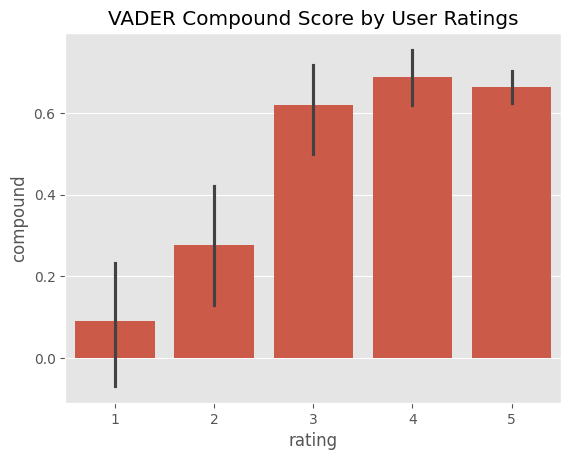

In [40]:
ax = sns.barplot(data=df_sub, x='rating', y='compound')
ax.set_title('VADER Compound Score by User Ratings')
plt.show()

Looking at individual negative, neutral and positive VADER scores

In [41]:
unique_ratings = df_sub['rating'].nunique()
palette = sns.color_palette("deep", unique_ratings)

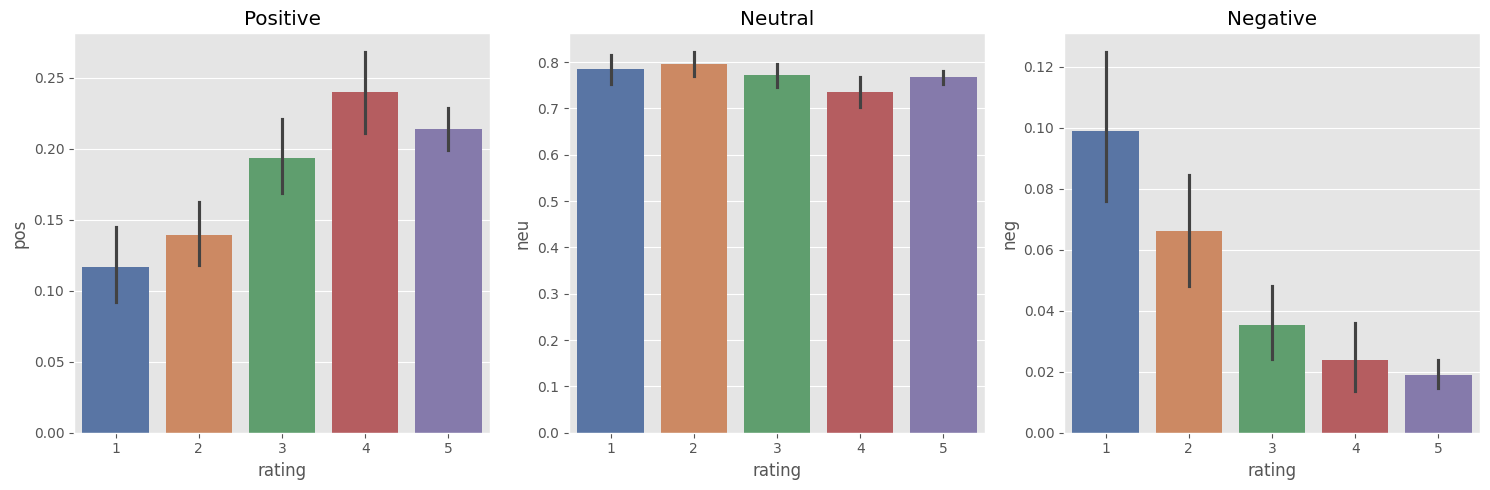

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=df_sub, x='rating', y='pos', hue='rating', ax=axs[0], palette=palette, legend=False)
sns.barplot(data=df_sub, x='rating', y='neu', hue='rating', ax=axs[1], palette=palette, legend=False)
sns.barplot(data=df_sub, x='rating', y='neg', hue='rating', ax=axs[2], palette=palette, legend=False)
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()

### RoBERTa Model

#### Brief Description

RoBERTa = Robustly optimized BERT model

Advantages of RoBERTa over VADER:
- It is a deep learning model based on Transformer architecture. It captures context of words in a sentence better.
- Trained on large datasets and learns from context
- Effectively handles change in language usage over time, slang, emerging terms etc. 
- Has versions to support multiple languages
- Can be fine-tuned on specific dataset
- More suitable for applications where the context and depth of language understanding are critical

##### Imports

In [47]:
# library from HuggingFace
from transformers import AutoTokenizer
# from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
# from scipy.special import softmax
import tensorflow as tf

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

##### VADER vs RoBERTa

In [50]:
# VADER results on example
print(example)
analyzer.polarity_scores(example)

Wow! Can’t go a night without putting this on! It’s incredible


{'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'compound': 0.658}

In [55]:
# Run for Roberta Model
encoded_example = tokenizer(example, return_tensors='tf')

output = model(encoded_example)

scores = tf.nn.softmax(output.logits, axis=1).numpy()

scores_dict = {
    'roberta_neg': scores[0][0],
    'roberta_neu': scores[0][1],
    'roberta_pos': scores[0][2]
}

print(scores_dict)

{'roberta_neg': 0.0021749649, 'roberta_neu': 0.011238973, 'roberta_pos': 0.9865861}


##### Function to be applied to the whole DataFrame

In [58]:
def analyze_sentiment(text):
    encoded_text = tokenizer(text, return_tensors='tf')

    output = model(encoded_text)

    scores = tf.nn.softmax(output.logits, axis=1).numpy()[0]

    return scores[0], scores[1], scores[2]

##### Apply `analyze_sentiment()` to the whole DataFrame

In [59]:
df_sub[['roberta_neg', 'roberta_neu', 'roberta_pos']] = df_sub['review_text'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

In [60]:
df_sub.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id,cleaned_review_text,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524,i use this with the nudestix citrus clean balm...,0.000,0.806,0.194,0.9392,0.001872,0.034517,0.963611
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263,i bought this lip mask after reading the revie...,0.079,0.825,0.096,0.1280,0.557232,0.321982,0.120786
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401,my review title says it all! i get so excited ...,0.052,0.905,0.042,-0.1240,0.085774,0.205051,0.709176
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851,i’ve always loved this formula for a long time...,0.000,0.707,0.293,0.9460,0.001832,0.008467,0.989701
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835,"if you have dry cracked lips, this is a must h...",0.000,0.940,0.060,0.3291,0.017095,0.146681,0.836224


### Compare Model Scores

In [61]:
df_sub.columns

Index(['review_id', 'review_text', 'product_id', 'rating', 'review_title',
       'is_recommended', 'author_id', 'cleaned_review_text', 'neg', 'neu',
       'pos', 'compound', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')

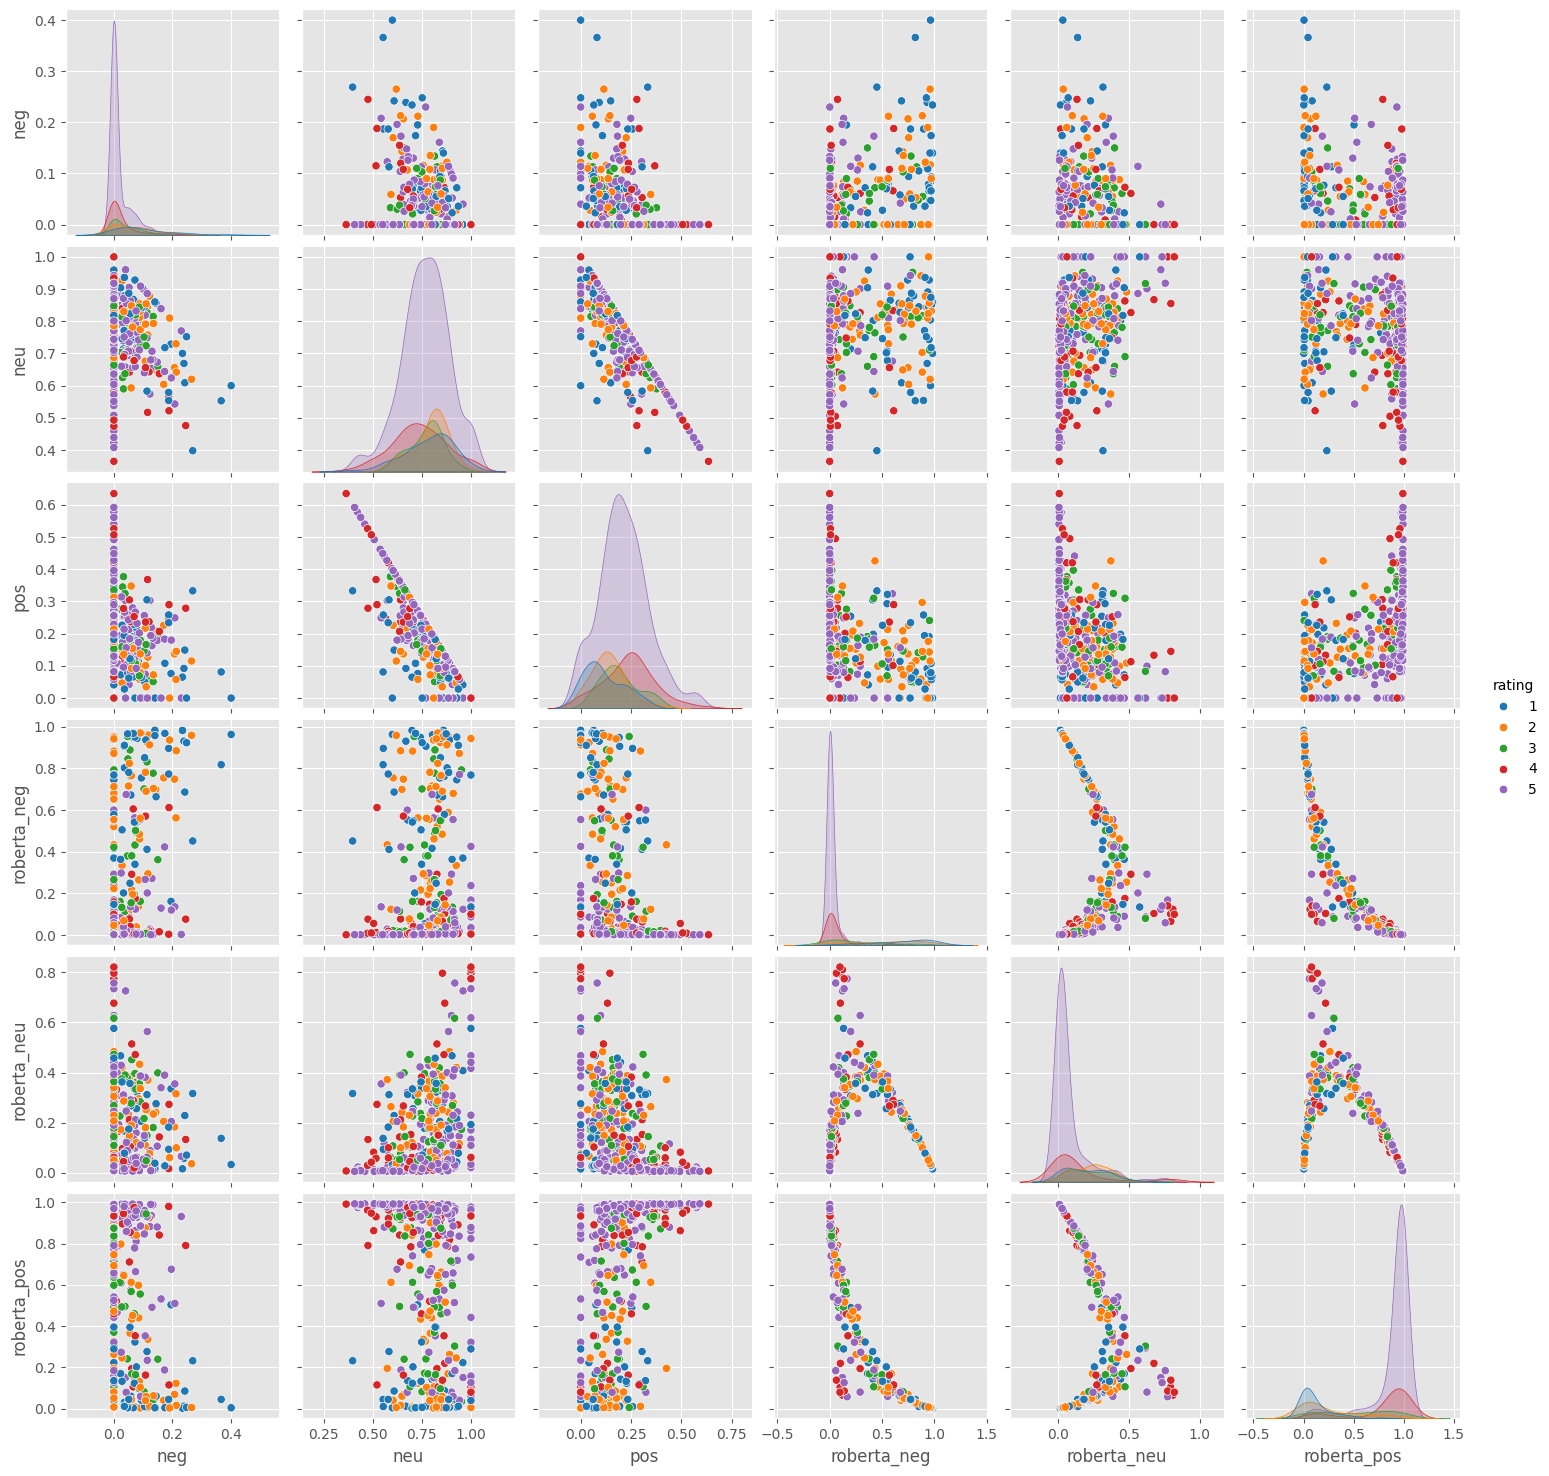

In [62]:
sns.pairplot(data=df_sub,
             vars=['neg', 'neu', 'pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
                  hue='rating',
                  palette='tab10')
plt.show()


### Review Examples 'Outliers'

We assume the following cases to be our "error" or "outlier" cases:

- Positive review  with Rating 1

- Negative review with Rating 5

In [65]:
# positive sentiment low rating review (RoBERTa)
df_sub.query('rating == 1') \
    .sort_values('roberta_pos', ascending=False)['review_text'].values[0]

'love the initial application because it layers so well on your lips and feels hydrated. But after 2 uses it began making my lips feel all chapped. Better off with vaseline'

In [66]:
# positive sentiment low rating review (VADER)
df_sub.query('rating == 1') \
    .sort_values('pos', ascending=False)['review_text'].values[0]

'I wanted to love it. Made my lips worse no matter what I did. Not worth it honestly. Only positive is it smells nice'

In [68]:
# negative sentiment high rating review (RoBERTa)
# turns out it isn't 
df_sub.query('rating == 5') \
    .sort_values('roberta_neg', ascending=False)['review_text'].values[0]

'my lips used to be so chapped i couldn’t wear gloss or anything. all i could wear was aquaphor or my lips could crack and bleed. this mask i wore 2 times and i don’t need anything on my lips at all. worth the money 110%!!'

In [69]:
# negative sentiment high rating review (VADER)
# turns out it isn't either
df_sub.query('rating == 5') \
    .sort_values('neg', ascending=False)['review_text'].values[0]

'insane product! so hydrating, is use it every morning and night'

### Transformers Pipelines

In [70]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/Users/jabbawocka/Desktop/SPICED/Project/product-recommendation/porefectionist/sentiment-analysis/Deliverables/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [71]:
# testing the wrongly classified review from above RoBERTa
# it is still wrong, probably due to the HuggingFace model 
sent_pipeline('love the initial application because it layers so well on your lips and feels hydrated. But after 2 uses it began making my lips feel all chapped. Better off with vaseline')

[{'label': 'POSITIVE', 'score': 0.9644908308982849}]

# References

### RoBERTa Resources

- **Original Paper on RoBERTa**
  - [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) - Yinhan Liu et al.

- **Hugging Face Models**
  - [Hugging Face - RoBERTa Models](https://huggingface.co/models?search=roberta)

- **BERT and RoBERTa Explained**
  - [The Illustrated BERT and RoBERTa](http://jalammar.github.io/illustrated-bert/)

### VADER Resources

- **Original Paper on VADER**
  - [VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text](https://ojs.aaai.org/index.php/ICWSM/article/view/14550) - C.J. Hutto and Eric Gilbert

- **GitHub Repository**
  - [VADER GitHub](https://github.com/cjhutto/vaderSentiment)

- **Practical Tutorial**
  - [VADER sentiment analysis tutorial on Towards Data Science](https://towardsdatascience.com) (Search for "VADER sentiment analysis" on the site)

### Additional Learning Resources

- **Books on NLP**
  - "Natural Language Processing with Python" by Steven Bird, Ewan Klein, and Edward Loper

- **Online Courses**
  - [Coursera - Natural Language Processing](https://www.coursera.org)
  - [edX - Deep Learning Specialization](https://www.edx.org)
